# Working Up to a Searchlight

### note that for right now I'm doing search light in anatomical parcels similar to our rois - not full ventral masks

In [1]:
# Cell 1: Setup and verify data for one subject
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib

# Paths
BASE_DIR = Path('/user_data/csimmon2/long_pt')
subject = 'sub-004'
session = '01'
sub_num = subject.replace('sub-', '')  # '004'

# Directories
func_base = BASE_DIR / subject / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'
cov_dir = BASE_DIR / subject / f'ses-{session}' / 'covs'
roi_dir = BASE_DIR / subject / f'ses-{session}' / 'ROIs'

# Find available runs
runs = sorted([d.name for d in func_base.glob('run-*') if d.is_dir()])
print(f"Available runs: {runs}")

# Verify functional data
for run in runs:
    func_file = func_base / run / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
    print(f"  {run}: {func_file.exists()}")

# Verify timing files (run-01)
print("\nTiming files (run-01):")
for cat in ['Face', 'Word', 'Object', 'House', 'Scramble']:
    timing_file = cov_dir / f'catloc_{sub_num}_run-01_{cat}.txt'
    print(f"  {cat}: {timing_file.exists()}")

# Verify search masks
print("\nSearch masks:")
for hemi in ['l', 'r']:
    for cat in ['face', 'word', 'object', 'house']:
        mask_file = roi_dir / f'{hemi}_{cat}_searchmask.nii.gz'
        print(f"  {hemi}_{cat}: {mask_file.exists()}")

Available runs: ['run-01', 'run-02', 'run-03', 'run-04']
  run-01: True
  run-02: True
  run-03: True
  run-04: False

Timing files (run-01):
  Face: True
  Word: True
  Object: True
  House: True
  Scramble: True

Search masks:
  l_face: True
  l_word: True
  l_object: True
  l_house: True
  r_face: False
  r_word: False
  r_object: False
  r_house: False


In [2]:
# Cell 2: Extract block patterns for one run
TR = 2.0
HRF_DELAY = 4  # seconds

# Load functional data
func_file = func_base / 'run-01' / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
func_img = nib.load(func_file)
func_data = func_img.get_fdata()
affine = func_img.affine
print(f"Functional shape: {func_data.shape}")  # (x, y, z, time)

# Load timing for Face
timing_file = cov_dir / f'catloc_{sub_num}_run-01_Face.txt'
timing = np.loadtxt(timing_file)
print(f"Timing: {timing.shape[0]} blocks, {timing[0,1]}s duration")

# Extract block patterns
def extract_blocks(func_data, timing, tr=2.0, hrf_delay=4):
    """Extract mean pattern for each block"""
    patterns = []
    for onset, duration, _ in timing:
        start_vol = int((onset + hrf_delay) / tr)
        end_vol = int((onset + duration + hrf_delay) / tr)
        end_vol = min(end_vol, func_data.shape[-1])
        
        block_mean = np.mean(func_data[..., start_vol:end_vol], axis=-1)
        patterns.append(block_mean)
    return np.array(patterns)

face_patterns = extract_blocks(func_data, timing)
print(f"Face patterns shape: {face_patterns.shape}")  # (3, x, y, z)

Functional shape: (176, 256, 256, 184)
Timing: 3 blocks, 16.0s duration
Face patterns shape: (3, 176, 256, 256)


In [3]:
# Cell 3: Extract patterns for Face vs Scramble, apply mask
categories = ['Face', 'Scramble']

# Load search mask
mask_file = roi_dir / 'l_face_searchmask.nii.gz'
mask_img = nib.load(mask_file)
mask_data = mask_img.get_fdata() > 0
print(f"Mask voxels: {np.sum(mask_data)}")

# Extract patterns for all runs
all_patterns = []
all_labels = []
all_runs = []

for run in ['run-01', 'run-02', 'run-03']:
    func_file = func_base / run / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
    func_data = nib.load(func_file).get_fdata()
    
    run_num = int(run.split('-')[1])
    
    for cat_idx, cat in enumerate(categories):
        timing_file = cov_dir / f'catloc_{sub_num}_{run}_{cat}.txt'
        timing = np.loadtxt(timing_file)
        
        patterns = extract_blocks(func_data, timing)
        
        for p in patterns:
            all_patterns.append(p)
            all_labels.append(cat_idx)  # 0=Face, 1=Scramble
            all_runs.append(run_num)

X = np.array(all_patterns)
y = np.array(all_labels)
runs = np.array(all_runs)

print(f"X shape: {X.shape}")  # (n_samples, x, y, z)
print(f"Labels: {np.bincount(y)} (Face, Scramble)")
print(f"Runs: {np.bincount(runs)[1:]}")  # blocks per run

Mask voxels: 19331
X shape: (18, 176, 256, 256)
Labels: [9 9] (Face, Scramble)
Runs: [6 6 6]


In [ ]:
# Cell 4: Searchlight setup
from nilearn.decoding import SearchLight
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut

# Apply mask to restrict searchlight
from nilearn.image import new_img_like

# Create 4D image from patterns
X_img = new_img_like(mask_img, np.transpose(X, (1, 2, 3, 0)))

# Classifier and CV
clf = SVC(kernel='linear')
cv = LeaveOneGroupOut()

# Searchlight
sl = SearchLight(
    mask_img=mask_img,
    radius=6,  # mm
    estimator=clf,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print(f"Ready to fit searchlight")
print(f"  Samples: {len(y)}")
print(f"  CV folds: {len(np.unique(runs))}")

/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


Ready to fit searchlight
  Samples: 18
  CV folds: 3


In [14]:
# Cell 4c: Test on subset of mask
from scipy.ndimage import binary_erosion

# Erode mask to get smaller test region
test_mask = binary_erosion(mask_data, iterations=2)
print(f"Original voxels: {np.sum(mask_data)}")
print(f"Test voxels: {np.sum(test_mask)}")

#test_mask_img = new_img_like(mask_img, test_mask.astype(float))

Original voxels: 19331
Test voxels: 7543


In [ ]:
# Cell 4d: BrainIAK searchlight
from brainiak.searchlight.searchlight import Searchlight, Ball
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut

# Reshape data for brainiak: (x, y, z, samples)
data_4d = np.transpose(X, (1, 2, 3, 0))

def svm_cv(data, sl_mask, myrad, bcvar):
    """Classification at each searchlight"""
    y, groups = bcvar
    bold = data[0].reshape(-1, data[0].shape[-1]).T  # (samples, voxels)
    
    if bold.shape[1] < 5:
        return 0.5
    
    clf = SVC(kernel='linear')
    cv = LeaveOneGroupOut()
    scores = cross_val_score(clf, bold, y, cv=cv, groups=groups)
    return np.mean(scores)

sl = Searchlight(sl_rad=6, max_blk_edge=5, shape=Ball)
sl.distribute([data_4d], mask_data.astype(int))
sl.broadcast((y, runs))
   
print("Running BrainIAK searchlight...")
results = sl.run_searchlight(svm_cv, pool_size=1)
print("Done")

Running BrainIAK searchlight...
Done


Map shape: (176, 256, 256)
Max accuracy: 1.00


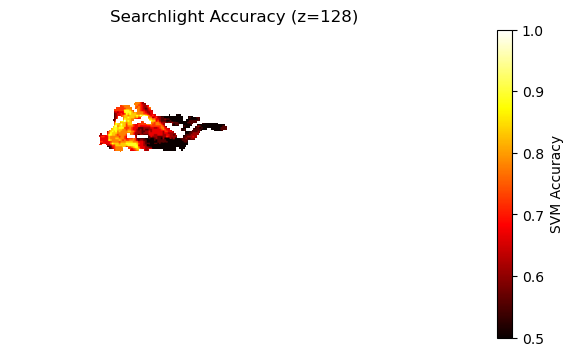

In [9]:
# 1. 'results' is ALREADY the 3D map, but likely holds 'None' for outside voxels
# We convert it to a float array, which turns 'None' -> 'NaN' automatically
accuracy_map = np.array(results, dtype=float)

# 2. Check the shape (It should match your original data dimensions, e.g., 64x64x30)
print(f"Map shape: {accuracy_map.shape}")
print(f"Max accuracy: {np.nanmax(accuracy_map):.2f}")

# 3. Visualize it
import matplotlib.pyplot as plt

# Pick a middle slice (change '30' to a valid z-slice for your brain)
z_slice = accuracy_map.shape[2] // 2 

plt.figure(figsize=(10, 4))
# 'hot' cmap makes high accuracy red/yellow, low accuracy black
plt.imshow(accuracy_map[:, :, z_slice], cmap='hot', vmin=0.5, vmax=1.0)
plt.colorbar(label='SVM Accuracy')
plt.title(f'Searchlight Accuracy (z={z_slice})')
plt.axis('off')
plt.show()